<a href="https://colab.research.google.com/github/s-mostafa-a/pytorch_learning/blob/master/fast_ai/lesson_three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if you go to top 10% of kaggle competition, you probably know what you'er doing so it's really good!
# getting data from the folder form into a form that you can feed your model is the trickiest step!
# __getitem__() will be useful when you are calling Obj[3] it means Obj.__getitem__(3)!
# dataloader at pytorch is used to create mini batches to pass to sgd running in parallel at gpu
# databunch is something top of dataloader and it requires some validation set in addtion to the given training set (as dataloader)!
# function calling one after the other is awesome! (pipeline)
# metrics at create_cnn is not the thing that can affect your model at all. it is just to show you how it is going.
# partial is awesome!
# the idea of training images sized 64*64 and then fine tuning with 128*128 and then ... works very well and is awesome!
# the shown plot in which the loss due to learning rate a little bit goes up and then comes down is awesome!
# to_fp16() is for break down memory usage and is awesome!
# regression is for anytime which your output is some continues number!

In [2]:
from fastai.vision import *

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)

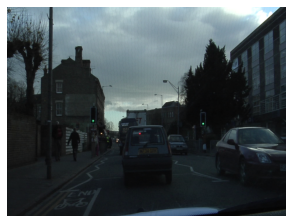

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

/root/.fastai/data/camvid/labels 0001TP_009750 .png
/root/.fastai/data/camvid/images


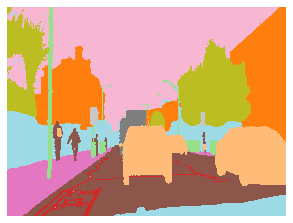

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
print(path_lbl, img_f.stem,img_f.suffix)
print(img_f.parent)

In [9]:


src_size = np.array(mask.shape[1:])
print(src_size)

size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else: bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")



[720 960]
using bs=8, have 15068MB of GPU RAM free


In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)


src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))


data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


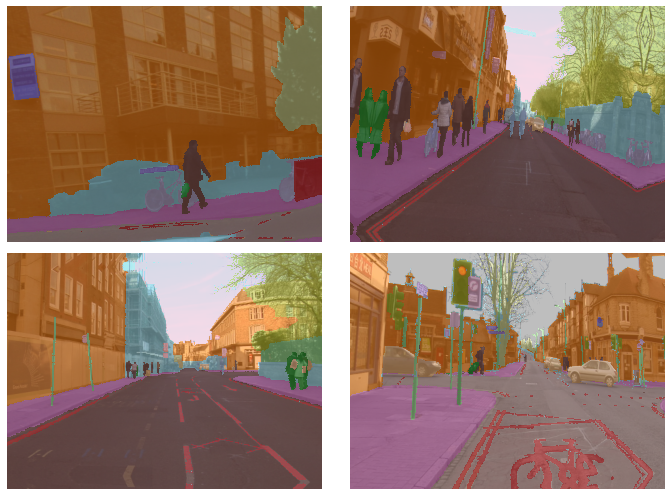

In [11]:
data.show_batch(2, figsize=(10,7))

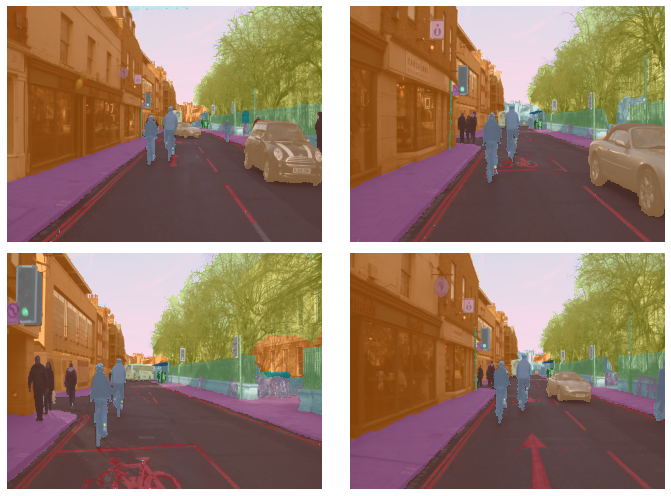

In [12]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [13]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [14]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [15]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


In [16]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


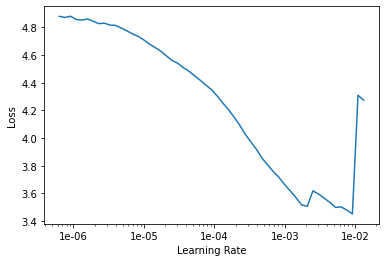

In [17]:
lr_find(learn)
learn.recorder.plot()

In [19]:
print(slice(3e-3))
learn.fit_one_cycle(10, slice(3e-3), pct_start=0.9)


slice(None, 0.003, None)


epoch,train_loss,valid_loss,acc_camvid,time
0,1.369349,0.943200,0.741214,01:29
1,0.854668,0.592513,0.837261,01:27
2,0.687064,0.527522,0.857540,01:27
3,0.656299,0.652400,0.830931,01:26
4,0.675836,0.533751,0.857755,01:26
5,0.577067,0.455708,0.872357,01:26
6,1.432185,1.354932,0.676246,01:25
7,1.092364,0.784411,0.808793,01:25
8,0.745031,0.568285,0.851932,01:25
9,0.592265,0.460771,0.868619,01:24


In [20]:
learn.save('stage-1')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

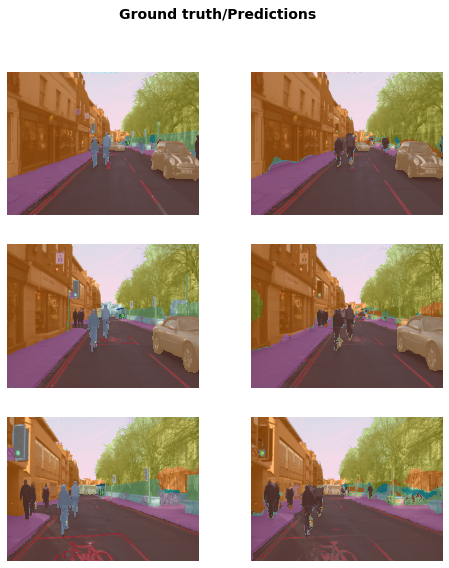

In [21]:
learn.show_results(rows=3, figsize=(8,9))

In [23]:
learn.unfreeze()
lrs = slice(3e-3/400,3e-3/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.500753,0.445260,0.871135,01:28
1,0.496408,0.428098,0.873215,01:28
2,0.473825,0.420833,0.874682,01:28
3,0.461283,0.393209,0.881698,01:28
4,0.436864,0.373940,0.887106,01:28
5,0.424317,0.360238,0.898704,01:28
6,0.396209,0.328866,0.903976,01:28
7,0.385963,0.347151,0.907016,01:28
8,0.367149,0.335766,0.909706,01:28
9,0.353847,0.311807,0.909709,01:29
